# Missing Data

## Generate data

In [1]:
set.seed(37)

suppressMessages({
    library('missForest')
})

getData <- function(N=1000) {
    x1 <- rnorm(N, mean=0, sd=1)
    x2 <- rnorm(N, mean=0, sd=1)
    y <- 5 + 3.2 * x1 - 4.2 * x2 + rnorm(N, mean=0, sd=1)
    df <- data.frame(x1=x1, x2=x2, y=y)
    return(df)
}

df <- getData()
df.mis <- prodNA(df, noNA=0.1)

## Visualize missingness

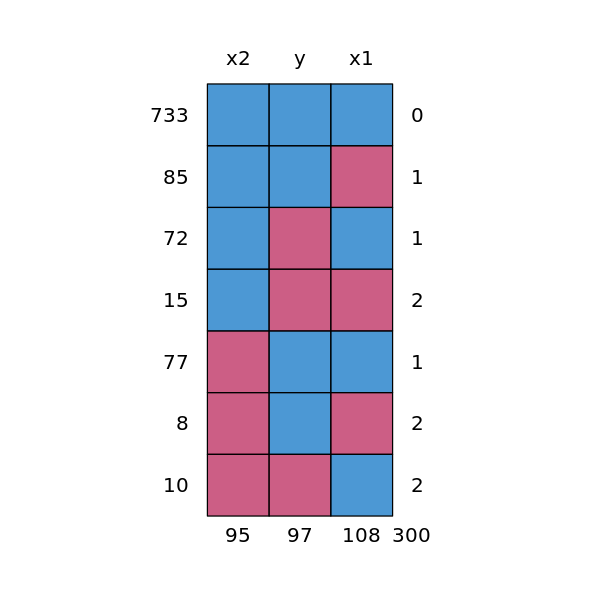

In [2]:
suppressMessages({
    library('mice')
})

options(repr.plot.width=5, repr.plot.height=5)

p <- md.pattern(df.mis)


 Variables sorted by number of missings: 
 Variable Count
       x1 0.108
        y 0.097
       x2 0.095


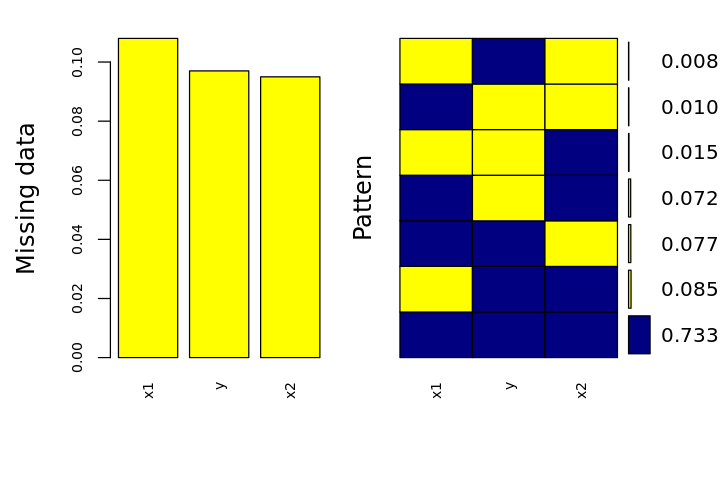

In [3]:
suppressMessages({
    library('VIM')
}) 

options(repr.plot.width=6, repr.plot.height=4)

p <- aggr(
    df.mis, 
    col=c('navyblue','yellow'), 
    numbers=TRUE, 
    sortVars=TRUE, 
    labels=names(df.mis), 
    cex.axis=.7, 
    gap=3, 
    ylab=c('Missing data', 'Pattern')
)

## MICE

This approach imputes 5 datasets using [mice](https://cran.r-project.org/web/packages/mice/mice.pdf).

In [4]:
df.imp <- mice(df.mis, m=5, maxit=50, method='pmm', seed=500, print=FALSE)

print(summary(df.imp))

Class: mids
Number of multiple imputations:  5 
Imputation methods:
   x1    x2     y 
"pmm" "pmm" "pmm" 
PredictorMatrix:
   x1 x2 y
x1  0  1 1
x2  1  0 1
y   1  1 0
NULL


In [5]:
df.model <- with(data=df.imp, exp=lm(y ~ x1 + x2))
df.combine = pool(df.model)
print(summary(df.combine))

             estimate  std.error  statistic       df p.value
(Intercept)  4.978536 0.03615236  137.70984 59.17146       0
x1           3.224436 0.03845041   83.85961 28.21157       0
x2          -4.201357 0.04062838 -103.40940 21.56991       0


## Amelia

Using [Amelia](https://cran.r-project.org/web/packages/Amelia/Amelia.pdf).

In [6]:
suppressMessages({
    library('Amelia')
})

df.imp <- amelia(df.mis, m=5, parallel='multicore', print=FALSE)

-- Imputation 1 --

  1  2  3

-- Imputation 2 --

  1  2  3

-- Imputation 3 --

  1  2  3

-- Imputation 4 --

  1  2  3

-- Imputation 5 --

  1  2  3



In [7]:
m <- lm(y ~ x1 + x2, data=df.imp$imputations[[1]])
print(summary(m))


Call:
lm(formula = y ~ x1 + x2, data = df.imp$imputations[[1]])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7700 -0.6489  0.0266  0.6592  3.4818 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.01673    0.03138   159.9   <2e-16 ***
x1           3.23168    0.03058   105.7   <2e-16 ***
x2          -4.19395    0.03082  -136.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9918 on 997 degrees of freedom
Multiple R-squared:  0.9691,	Adjusted R-squared:  0.969 
F-statistic: 1.563e+04 on 2 and 997 DF,  p-value: < 2.2e-16



## missForest

Use [missForest](https://cran.r-project.org/web/packages/missForest/missForest.pdf).

In [8]:
df.imp <- missForest(df.mis, verbose=FALSE)

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!


In [9]:
m <- lm(y ~ x1 + x2, data=df.imp$ximp)
print(summary(m))


Call:
lm(formula = y ~ x1 + x2, data = df.imp$ximp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2084 -0.5477  0.0094  0.5762  3.4938 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.99766    0.02881   173.5   <2e-16 ***
x1           3.24033    0.02854   113.5   <2e-16 ***
x2          -4.19705    0.02872  -146.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9104 on 997 degrees of freedom
Multiple R-squared:  0.9733,	Adjusted R-squared:  0.9733 
F-statistic: 1.82e+04 on 2 and 997 DF,  p-value: < 2.2e-16



## Hmisc

Use [Hmisc](https://cran.r-project.org/web/packages/Hmisc/Hmisc.pdf).

In [10]:
suppressMessages({
    library('Hmisc')
})

df.imp <- aregImpute(~ x1 + x2 + y, data=df.mis, n.impute=5)

Iteration 8 


In [11]:
print(fit.mult.impute(y ~ x1 + x2, glm, df.imp, data=df))


Variance Inflation Factors Due to Imputation:

(Intercept)          x1          x2 
       1.32        1.40        1.03 

Rate of Missing Information:

(Intercept)          x1          x2 
       0.24        0.29        0.03 

d.f. for t-distribution for Tests of Single Coefficients:

(Intercept)          x1          x2 
      68.07       48.58     6034.09 

The following fit components were averaged over the 5 model fits:

  fitted.values linear.predictors 


Call:  fit.mult.impute(formula = y ~ x1 + x2, fitter = glm, xtrans = df.imp, 
    data = df)

Coefficients:
(Intercept)           x1           x2  
      4.986        3.224       -4.200  

Degrees of Freedom: 999 Total (i.e. Null);  997 Residual
Null Deviance:	    31230 
Residual Deviance: 1058 	AIC: 2902


## mi

Impute using [mi](https://cran.r-project.org/web/packages/mi/mi.pdf).

In [12]:
suppressMessages({
    library('mi')
})

df.imp <- mi(df.mis, seed=37)

In [13]:
summary(df.imp)

$x1
$x1$is_missing
missing
FALSE  TRUE 
  892   108 

$x1$imputed
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.452751 -0.300690  0.054950  0.007345  0.370627  1.108615 

$x1$observed
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.370380 -0.340412 -0.007915  0.000000  0.346205  1.855986 


$x2
$x2$is_missing
missing
FALSE  TRUE 
  905    95 

$x2$imputed
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.03500 -0.35484 -0.05427 -0.03926  0.26938  1.48688 

$x2$observed
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.63933 -0.30576  0.02156  0.00000  0.32167  1.53286 


$y
$y$is_missing
missing
FALSE  TRUE 
  903    97 

$y$imputed
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.54359 -0.28016  0.05029  0.04386  0.39540  1.12524 

$y$observed
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-1.5729109 -0.3407619  0.0007829  0.0000000  0.3281380  1.5120664 

